In [42]:
import pandas as pd
import numpy as np
import glob
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error, precision_score, recall_score, accuracy_score, f1_score, r2_score
from sklearn.model_selection import validation_curve, learning_curve, cross_val_score, StratifiedKFold
import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import HyperbandSearchCV, GridSearchCV 
from dask_ml.model_selection import KFold
from dask_ml.linear_model import LogisticRegression
import dask.array as da

In [2]:
import imblearn
from imblearn.over_sampling import SMOTE 

In [3]:
start_time = time.time() 

In [4]:
client = Client()

C:\Users\stack\AppData\Roaming\Python\Python312\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55406 instead
  warnings.warn(


In [5]:
asteroid_df = dd.read_csv("data/asteroid_normalized_small_df.csv")
asteroid_df = asteroid_df.drop(columns = ['diameter', 'albedo', 'a', 'i', 'neo']) #, inplace = True)

# Repartition the DataFrame to a specific number of partitions
desired_partitions = 8
asteroid_df = asteroid_df.repartition(npartitions=desired_partitions)

asteroid_df

,pha,H,e,q,n,moid,spkid,full_name
npartitions=8,,,,,,,,
,int64,float64,float64,float64,float64,float64,int64,string
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [6]:
print(asteroid_df.dtypes)

pha                    int64
H                    float64
e                    float64
q                    float64
n                    float64
moid                 float64
spkid                  int64
full_name    string[pyarrow]
dtype: object


## Split data

In [7]:
exclude_col = ['pha', 'spkid', 'full_name']
X = asteroid_df.drop(columns = exclude_col)
y = asteroid_df.iloc[:, 0]

X = X.to_dask_array(lengths=True)
y = y.to_dask_array(lengths=True)

In [8]:
#from sklearn.model_selection import train_test_split
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [9]:
# Check the number of partitions in X_train and y_train
num_partitions_X = X_train.npartitions
num_partitions_y = y_train.npartitions

print(f'Number of partitions in X_train: {num_partitions_X}')
print(f'Number of partitions in y_train: {num_partitions_y}')

Number of partitions in X_train: 8
Number of partitions in y_train: 8


In [10]:
X_train.shape, y_train.shape

((110333, 5), (110333,))

In [11]:
X_test.shape, y_test.shape

((27584, 5), (27584,))

## logistic regression model

In [12]:
#from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)    # Train the model using the training sets

LogisticRegression()

In [13]:
pd.DataFrame({"Accurancy on Train":[accuracy_score(y_train, logreg.predict(X_train))],
    "Accurancy on Test":[accuracy_score(y_test, logreg.predict(X_test))]})

,Accurancy on Train,Accurancy on Test
0,0.997807,0.997354


In [14]:
# Predict on the test data set
y_pred = logreg.predict(X_test)

#### Model slop and intercept

In [15]:
print("Number of coefficients:", len(logreg.coef_))
print("Estimated coefficients: {}".format(logreg.coef_))
print("Estimated intercept: {}".format(logreg.intercept_))

Number of coefficients: 5
Estimated coefficients: [-0.24933917  0.03770837  0.83983168  0.10239516 -5.49075805]
Estimated intercept: -12.0234283722733


### Evaluate logistic regression model

In [16]:
target_names = ['non-PHA', 'PHA']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     non-PHA       1.00      1.00      1.00     27511
         PHA       0.00      0.00      0.00        73

    accuracy                           1.00     27584
   macro avg       0.50      0.50      0.50     27584
weighted avg       0.99      1.00      1.00     27584



C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[27511,     0],
       [   73,     0]], dtype=int64)

#### RMS

In [18]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE value : {:.2f}".format(rmse))

RMSE value : 0.05


#### Model slop and intercept

#### R2

In [19]:
print("R2 Score value: {:.2f}".format(r2_score(y_test, y_pred)))

R2 Score value: -0.00


In [20]:
print("Training set score: {:.2f}".format(logreg.score(X_train.compute(), y_train.compute)))

Training set score: 0.00


In [21]:
print("Test set score: {:.2f}".format(logreg.score(X_test.compute(), y_test.compute())))

Test set score: 1.00


#### Cross-validation

In [22]:
# Compute 5-fold cross-validation scores: cv_scores
X_p = X.compute()
y_p = y.compute()
cv_scores = cross_val_score(logreg, X_p, y_p, cv=5)

In [23]:
# print the 5-fold cross-validation scores
print(cv_scores.round(4))

[1.     1.     1.     1.     0.9886]


In [24]:
# print the avarage 5-fold cross-validation scores
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores).round(4)))

Average 5-Fold CV Score: 0.9977


### Plotting Residual Error

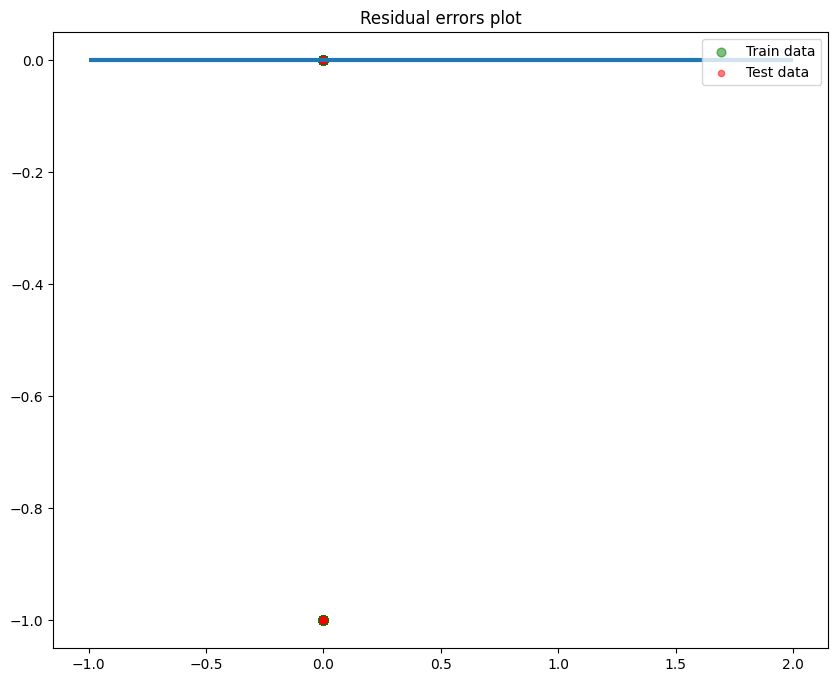

In [25]:
%matplotlib inline
plt.figure(figsize=(10,8))

# Compute predictions and residuals for training data
y_train_pred = logreg.predict(X_train)  # Prediction for training data
y_train_actual = y_train.compute()                # Actual training data values

# Compute predictions and residuals for test data
y_test_pred = logreg.predict(X_test)    # Prediction for test data
y_test_actual = y_test.compute()                  # Actual test data values

# Plot residual errors for training data
plt.scatter(y_train_pred, y_train_pred - y_train_actual, c='g', s=40, label='Train data', alpha=0.5)

# Plot residual errors for test data
plt.scatter(y_test_pred, y_test_pred - y_test_actual, c='r', s=20, label='Test data', alpha=0.5)

# plotting line for zero residual error
plt.hlines(y = 0, xmin = -1, xmax = 2, linewidth = 3)

# plotting legend
plt.legend(loc = 'upper right')

# plot title
plt.title("Residual errors plot")

# function to show plot
plt.show()

In [26]:
precision_metric_macro = precision_score(y_test, y_pred, average = "macro")
recall_metric_macro = recall_score(y_test, y_pred, average = "macro")
accuracy_metric = accuracy_score(y_test, y_pred)
f1_metric_macro = f1_score(y_test, y_pred, average = "macro")
    
print('Precision metric:',round(precision_metric_macro, 2))
print('Recall Metric:',round(recall_metric_macro, 2))
print('Accuracy Metric:',round(accuracy_metric, 4))
print('F1 score:',round(f1_metric_macro, 2))

C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision metric: 0.5
Recall Metric: 0.5
Accuracy Metric: 0.9974
F1 score: 0.5


In [27]:
precision_metric_micro = precision_score(y_test, y_pred, average = "micro")
recall_metric_micro = recall_score(y_test, y_pred, average = "micro")
f1_metric_micro = f1_score(y_test, y_pred, average = "micro")
    
print('Precision metric:',round(precision_metric_micro, 2))
print('Recall Metric:',round(recall_metric_micro, 2))
print('F1 score:',round(f1_metric_micro, 2))

Precision metric: 1.0
Recall Metric: 1.0
F1 score: 1.0


In [28]:
precision_metric_weighted = precision_score(y_test, y_pred, average = "weighted")
recall_metric_weighted = recall_score(y_test, y_pred, average = "weighted")
f1_metric_weighted = f1_score(y_test, y_pred, average = "weighted")
    
print('Precision metric:',round(precision_metric_weighted, 2))
print('Recall Metric:',round(recall_metric_weighted, 2))
print('F1 score:',round(f1_metric_weighted, 2))

C:\ProgramData\anaconda3\envs\CAS_ML\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision metric: 0.99
Recall Metric: 1.0
F1 score: 1.0


### Q-Q Plot

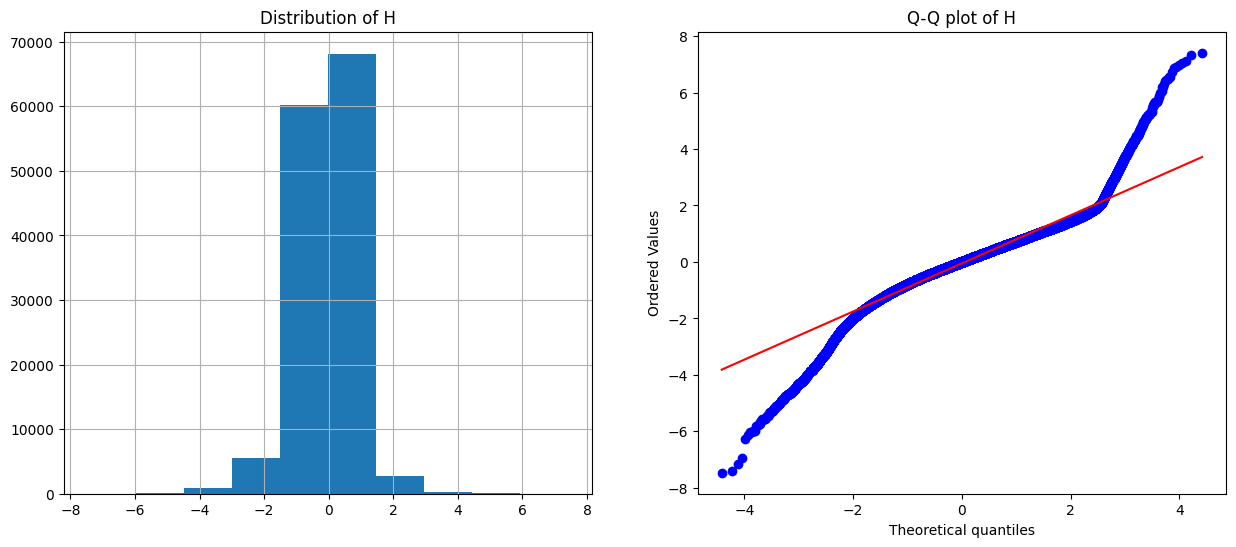

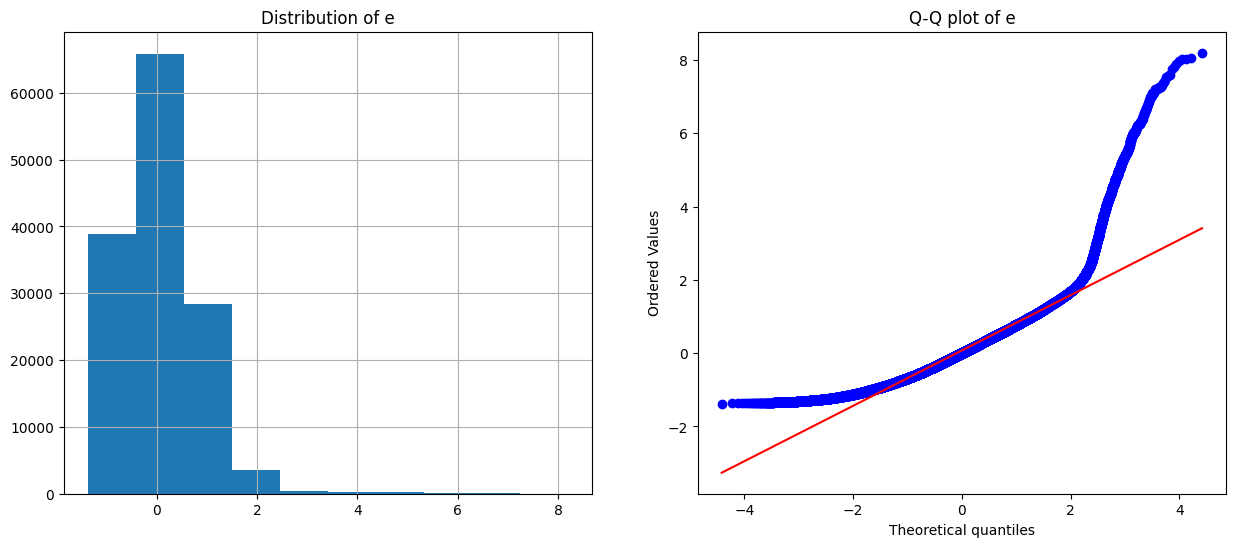

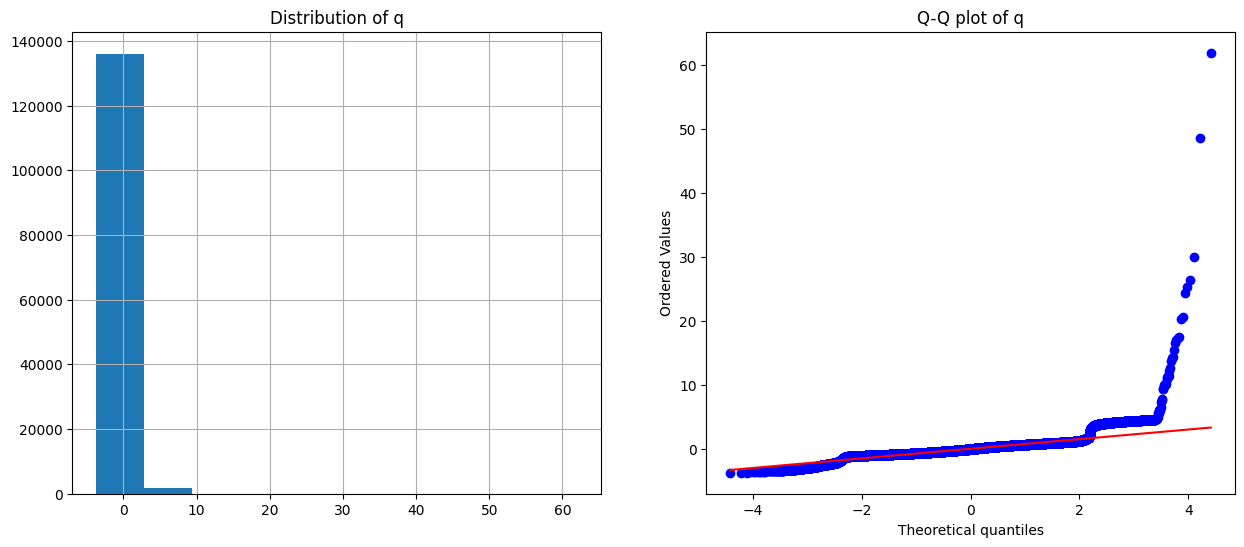

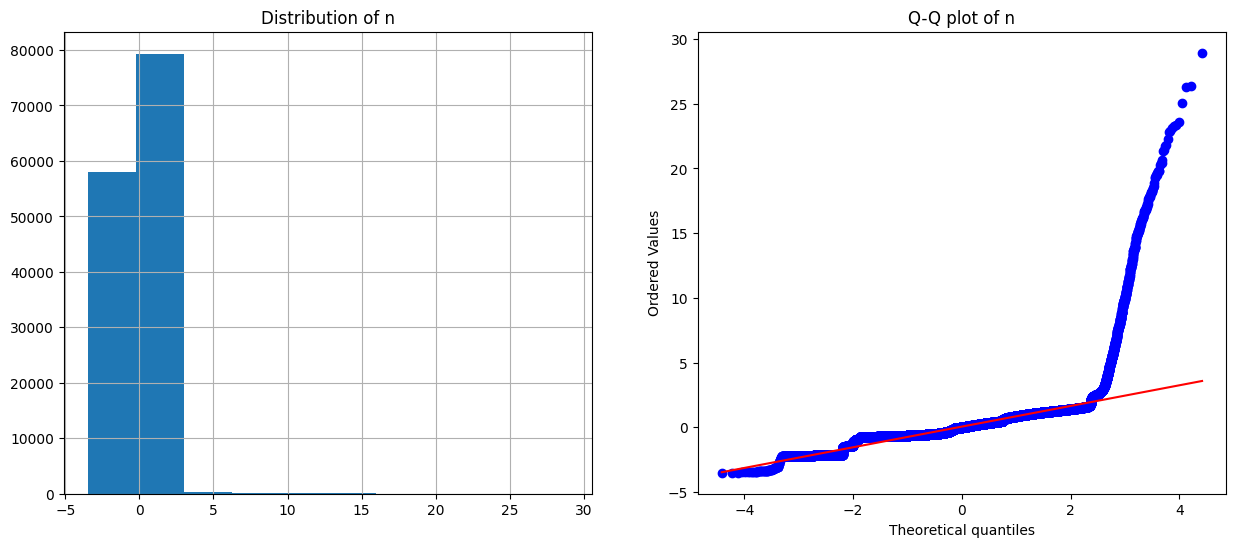

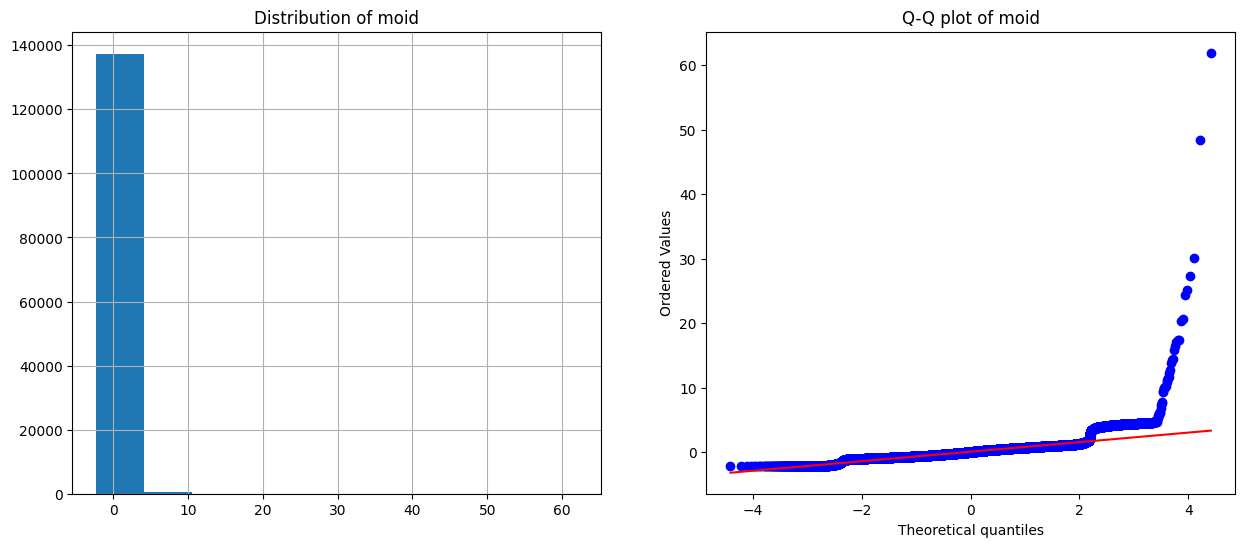

In [29]:
import pylab 
import scipy.stats as stats

exclude_col = ['pha', 'spkid', 'full_name']
asteroid_plot = asteroid_df.drop(columns = exclude_col)         

for var in asteroid_plot.columns:
        plt.figure(figsize=(15, 6))
        
        var_data = asteroid_plot[var].compute()
        
        # Histogram of the variable
        plt.subplot(1, 2, 1)
        var_data.hist()
        plt.title('Distribution of ' + var)

        # Q-Q plot for normality
        plt.subplot(1, 2, 2)
        stats.probplot(var_data, dist="norm", plot=pylab)
        plt.title('Q-Q plot of ' + var)

        # Display the plots
        plt.show()

## Validation in Practice: Grid Search

In [ ]:
param_grid = {
    'penalty': ['l2'],  # Regularization penalty types   removed , 'elasticnet'
    'C': [ 1, 10, 20],  # Regularization strength (inverse)
    'solver': ['newton-cg', 'lbfgs'],  # Solvers for optimization  removed , 'liblinear', 'saga'
    'max_iter': [300]  # Maximum number of iterations for convergence
    #'l1_ratio': [0, 0.5, 1]  # Only used with 'elasticnet' penalty
}

# Initialize logistic regression model
logreg = LogisticRegression()

# Initialize GridSearchCV with logistic regression and the parameter grid
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs = 1, scoring='accuracy')

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
try:
    grid_search.fit(X_train, y_train)
except Exception as e:
    print("Error during fitting:", e)

('logisticregression-fit-score-80a9d90e698eb3e1b7c9b8e56587ea97', 4, 2) has failed... retrying
('logisticregression-fit-score-80a9d90e698eb3e1b7c9b8e56587ea97', 0, 1) has failed... retrying
('logisticregression-fit-score-80a9d90e698eb3e1b7c9b8e56587ea97', 0, 2) has failed... retrying
('logisticregression-fit-score-80a9d90e698eb3e1b7c9b8e56587ea97', 2, 2) has failed... retrying
('logisticregression-fit-score-80a9d90e698eb3e1b7c9b8e56587ea97', 4, 3) has failed... retrying
('logisticregression-fit-score-80a9d90e698eb3e1b7c9b8e56587ea97', 4, 0) has failed... retrying
('logisticregression-fit-score-80a9d90e698eb3e1b7c9b8e56587ea97', 2, 1) has failed... retrying
('logisticregression-fit-score-80a9d90e698eb3e1b7c9b8e56587ea97', 0, 0) has failed... retrying
('logisticregression-fit-score-80a9d90e698eb3e1b7c9b8e56587ea97', 0, 4) has failed... retrying
('logisticregression-fit-score-80a9d90e698eb3e1b7c9b8e56587ea97', 2, 3) has failed... retrying
('logisticregression-fit-score-80a9d90e698eb3e1b7c

KeyboardInterrupt: 

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

In [ ]:
logreg_best = LogisticRegression(penalty = 'l2', C = 20, max_iter =  300, solver = 'newton-cg')

## Validation in Practice: Hyperband Search CV

In [39]:
param_grid = {
    'penalty': ['l2'], ##, 'elasticnet'],  # Regularization penalty types
    'C': [ 1, 10, 20],  # Regularization strength (inverse)
    'solver': ['lbfgs', 'liblinear'], ##, 'saga', 'newton-cg', ],  # Solvers for optimization
    'max_iter': [100]  ##,  # Maximum number of iterations for convergence
    ##'l1_ratio': [0, 0.5, 1]  # Only used with 'elasticnet' penalty
}

# Initialize logistic regression model
logreg = LogisticRegression()

# Create HyperbandSearchCV object
hyperband_search = HyperbandSearchCV(estimator = logreg, parameters = param_grid, max_iter = 300, scoring='accuracy', verbose = 1)

In [44]:
# Fit the model
classes = da.unique(y)
hyperband_search.fit(X_train, y_train, classes=classes)

[CV, bracket=5] creating 6 models
[CV, bracket=4] creating 6 models
[CV, bracket=3] creating 6 models
[CV, bracket=2] creating 6 models
[CV, bracket=1] creating 6 models
[CV, bracket=0] creating 6 models


2024-10-30 16:15:56,552 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('values-c954068a185a54d1c43ce61b3224a4df', 5) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x000001A5CE2E1DA0>, (('repartitiontomore-values-c954068a185a54d1c43ce61b3224a4df', 5),), {})
new run_spec: (subgraph_callable-2da6b6e8273b5b8ebe7ccf076c0f1a7e, (('repartitiontomore-45b828de549e339970d03979af700940', 5), 'repartitiontomore-45b828de549e339970d03979af700940'), {})
old token: ('tuple', (('80935a1067ef908b', []), ('tuple', (('tuple', ('repartitiontomore-values-c954068a185a54d1c43ce61b3224a4df', 

[CV, bracket=4] For training there are between 12067 and 12068 examples in each chunk
[CV, bracket=0] For training there are between 12067 and 12068 examples in each chunk
[CV, bracket=5] For training there are between 12067 and 12068 examples in each chunk
[CV, bracket=2] For training there are between 12067 and 12068 examples in each chunk
[CV, bracket=1] For training there are between 12067 and 12068 examples in each chunk
[CV, bracket=3] For training there are between 12067 and 12068 examples in each chunk


AttributeError: 'LogisticRegression' object has no attribute 'partial_fit'

In [ ]:
print("Best Parameters:", hyperband_search.best_params_)
print("Best Cross-Validation Score:", hyperband_search.best_score_)
hyperband_search.cv_results_

In [ ]:
logreg_best = LogisticRegression(penalty = 'l2', C = 20, max_iter =  300, solver = 'newton-cg')

## Heatmap for Hyperparameter Grid Search Results

In [ ]:
# Assuming grid_search.cv_results_ is available after running GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)
grouped_results = results.groupby(["param_C", "param_penalty"])["mean_test_score"].mean().reset_index()

# Pivot to create the scores matrix
scores_matrix = grouped_results.pivot(index="param_C", columns="param_penalty", values="mean_test_score")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".5f", cmap="viridis")
plt.title("Heatmap of Cross-Validation Accuracy")
plt.xlabel("Penalty")
plt.ylabel("C")
plt.show()


## Validation Curve (for a Single Hyperparameter)

In [ ]:
param_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, val_scores = validation_curve(
    LogisticRegression(),
    X_train, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="accuracy"
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training score", color="blue")
plt.plot(param_range, np.mean(val_scores, axis=1), label="Validation score", color="red")
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Validation Curve for Logistic Regression")
plt.xscale("log")  # Log scale for C
plt.legend()
plt.show()

## Learning Curves (Training vs. Cross-Validation Performance)

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    logreg_best, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 5)
)

# Mean and standard deviation for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, val_mean, label="Cross-validation score", color="red")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="red", alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve for Logistic Regression")
plt.legend()
plt.show()

### Model validation via cross-validation

In [ ]:
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
logreg.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = logreg.predict(X2)
accuracy_score(y2, y2_model)

In [ ]:
y2_model = logreg.fit(X1, y1).predict(X2)
y1_model = logreg.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

In [ ]:
cross_val_score(logreg, X, y, cv=5)

In [ ]:
skf = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)
scores = cross_val_score(logreg, X, y, cv=skf)
scores

#With 9 splits
#array([0.99869494, 0.99869486, 0.99895589, 0.99876011, 0.9990864 ,
#       0.99895589, 0.9990864 , 0.99876011, 0.99869486])
#With 25 splits
#array([0.99927497, 0.99818742, 0.99945623, 0.99891245, 0.99800616,
#       0.99927497, 0.99836868, 0.99873119, 0.99873119, 0.99873119,
#       0.99836868, 0.99927497, 0.99873119, 0.99873119, 0.99945623,
#       0.99854994, 0.99854994, 0.99927484, 0.99891226, 0.99891226,
#       0.99818709, 0.99927484, 0.99909355, 0.99873096, 0.99891226])

In [ ]:
scores.mean()
#With 9 Splits
#0.9988543845895842
#With 25 Splits
#0.9988253855214215

## Cross Validation without KFold

In [ ]:
kf = KFold(n_splits=55, shuffle=True, random_state=42)  
scores = cross_val_score(logreg, X, y, cv=kf)

In [ ]:
scores.mean()
#With 5 Splits
#0.9987818807344852
#With 55 Splits
#0.9988761292941168

In [ ]:
client.close()

In [ ]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")